In [1]:
!pip install recogym

## Offline

In [2]:
import gym, recogym

# env_0_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_args, Configuration

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False

# Counting how many steps.
i = 0

observation, reward, done = None, 0, False
while not done:
    action, observation, reward, done, info = env.step_offline(observation, reward, done)
    print(f"Step: {i} - Action: {action} - Observation: {observation.sessions()} - Reward: {reward}")
    i += 1

Step: 0 - Action: None - Observation: [{'t': 0, 'u': 0, 'z': 'pageview', 'v': 0}] - Reward: None
Step: 1 - Action: {'t': 1, 'u': 0, 'a': 3, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 2 - Action: {'t': 2, 'u': 0, 'a': 4, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0
Step: 3 - Action: {'t': 3, 'u': 0, 'a': 5, 'ps': 0.1, 'ps-a': ()} - Observation: [] - Reward: 0


## Online

In [3]:
# Create list of hard coded actions.
actions = [None] + [1, 2, 3, 4, 5]

# Reset env and set done to False.
env.reset()
done = False

# Counting how many steps.
i = 0

while not done and i < len(actions):
    action = actions[i]
    observation, reward, done, info = env.step(action)
    print(f"Step: {i} - Action: {action} - Observation: {observation.sessions()} - Reward: {reward}")
    i += 1

Step: 0 - Action: None - Observation: [{'t': 0, 'u': 0, 'z': 'pageview', 'v': 1}] - Reward: None
Step: 1 - Action: 1 - Observation: [] - Reward: 0
Step: 2 - Action: 2 - Observation: [] - Reward: 0
Step: 3 - Action: 3 - Observation: [] - Reward: 0
Step: 4 - Action: 4 - Observation: [] - Reward: 0
Step: 5 - Action: 5 - Observation: [{'t': 6, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 7, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 8, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 9, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 10, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 11, 'u': 0, 'z': 'pageview', 'v': 6}, {'t': 12, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 13, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 14, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 15, 'u': 0, 'z': 'pageview', 'v': 6}, {'t': 16, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 17, 'u': 0, 'z': 'pageview', 'v': 1}, {'t': 18, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 19, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 20, 'u': 0, 'z': 'pageview', 'v': 4}, {'t': 21, '

## Agents

In [0]:
import numpy as np
from numpy.random import choice
from recogym.agents import Agent

In [0]:
class PopularityAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(PopularityAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = np.zeros(self.config.num_products)

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                #print(session)
                self.organic_views[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        prob = self.organic_views / sum(self.organic_views)
        action = choice(self.config.num_products, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action]
            }
        }

    def __str__(self):
        return "Popularity Agent"

    def __repr__(self):
        return str(self)

In [0]:
from recogym import env_1_args

from copy import deepcopy

env_1_args['random_seed'] = 42
env_1_args['num_products'] = 10

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

# Import the random agent.
from recogym.agents import RandomAgent, random_args

# Create the two agents.
num_products = env_1_args['num_products']
popularity_agent = PopularityAgent(Configuration(env_1_args))
agent_rand = RandomAgent(Configuration({
    **env_1_args,
    **random_args,
}))

In [7]:
    
# Credible interval of the CTR median and 0.025 0.975 quantile.
recogym.test_agent(deepcopy(env), deepcopy(popularity_agent), 100, 100)

Offline Users:   0%|          | 0/100 [00:00<?, ?it/s]

Start: Agent Training #0


Online Users:   6%|▌         | 6/100 [00:00<00:01, 53.28it/s]

Start: Agent Testing #0


Online Users: 100%|██████████| 100/100 [00:02<00:00, 47.88it/s]

End: Agent Testing #0 (3.9404006004333496s)


(0.013166919176256748, 0.010795049195767067, 0.015858328147105638)

In [0]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

class UserSimilarityAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(UserSimilarityAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.user_items = pd.DataFrame(columns=range(self.config.num_products))
        
        self.organic_views = np.zeros(self.config.num_products)


    def train(self, observation, action, reward, done):

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1


        if observation is not None and len(observation.sessions()) > 0:

            user = observation.current_sessions[-1]['u']
            if not user in self.user_items.index:
                self.user_items.loc[user] = np.zeros((self.config.num_products))

            for elt in observation.sessions():
                item = elt['v']
                self.user_items.loc[[user], [item]] += 1

            

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""
            
        cos_similarity = cosine_similarity(self.user_items)

        prob = self.organic_views / sum(self.organic_views)

        if observation is not None and len(observation.current_sessions) > 0:
            current_user = observation.current_sessions[-1]['u']
            if not current_user in self.user_items.index:
                action = choice(self.config.num_products, p = prob)
            else:
                np.fill_diagonal(cos_similarity, 0)
                indexes = list(self.user_items.index)
                
                most_similar_user = np.argmax(cos_similarity[indexes.index(current_user), :])
                most_similar_user_items = self.user_items.iloc[most_similar_user]
                action = np.argmax(most_similar_user_items, axis=1)
                print(action)
        else:
            action = choice(self.config.num_products, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1#prob[action]
            }
        }

        def __str__(self):
            return "User Similarity Agent"

        def __repr(self):
            return str(self)

In [0]:
user_similarity_agent = UserSimilarityAgent(Configuration(env_1_args))

In [10]:
recogym.test_agent(deepcopy(env), deepcopy(user_similarity_agent), 10, 10)

Start: Agent Training #0


Online Users:  20%|██        | 2/10 [00:00<00:00, 12.17it/s]

Start: Agent Testing #0


Online Users: 100%|██████████| 10/10 [00:00<00:00, 12.82it/s]

End: Agent Testing #0 (2.6598355770111084s)


(0.011672477386144022, 0.005806308676390247, 0.020533159744478113)

In [0]:
import pandas as pd
from sklearn.cluster import KMeans

class ClusteringAgent(Agent):
    def __init__(self, config, nb_clusters):
        # Set number of products as an attribute of the Agent.
        super(ClusteringAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.user_items = pd.DataFrame(columns=range(self.config.num_products))
        
        self.organic_views = np.zeros(self.config.num_products)
        self.nb_clusters = nb_clusters
        self.kmeans = None
        self.nb_sessions = 0    #count the sessions
        self.training_rate = 10 #train each training_rate session to allow scaling

    def train(self, observation, action, reward, done):

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1


        if observation is not None and len(observation.sessions()) > 0:

            user = observation.current_sessions[-1]['u']
            if not user in self.user_items.index:
                self.user_items.loc[user] = np.zeros((self.config.num_products))

            for elt in observation.sessions():
                item = elt['v']
                self.user_items.loc[[user], [item]] += 1

        if self.user_items.shape[0] > self.nb_clusters and self.nb_sessions % 10 == 0:#if enought data and not trained since a few sessions
            self.kmeans = KMeans(n_clusters=self.nb_clusters, random_state=0).fit(self.user_items)

        self.nb_sessions += 1

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""
            
        prob = self.organic_views / sum(self.organic_views)

        if observation is not None and len(observation.current_sessions) > 0 and self.kmeans:
            history = np.zeros((self.config.num_products))
            for sess in observation.current_sessions:
                history[sess['v']] += 1
            
            history = history.reshape((1, history.shape[0]))#reshape because single data prediction
        
            pred = self.kmeans.predict(history)
            centroid = self.kmeans.cluster_centers_[pred]
            action = np.argmax(centroid)

        else:
            action = choice(self.config.num_products, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': 1#prob[action]
            }
        }

        def __str__(self):
            return "User Similarity Agent"

        def __repr(self):
            return str(self)

In [0]:
clustering_agent = ClusteringAgent(Configuration(env_1_args), nb_clusters=10)

In [63]:
recogym.test_agent(deepcopy(env), deepcopy(clustering_agent), 10, 10)

Start: Agent Training #0


Online Users:  40%|████      | 4/10 [00:00<00:00, 36.44it/s]

Start: Agent Testing #0


Online Users: 100%|██████████| 10/10 [00:00<00:00, 39.05it/s]

End: Agent Testing #0 (6.199362754821777s)


(0.010658530928051257, 0.005074107334803295, 0.01929643202006537)

## Benchmark for our agents

In [0]:
import matplotlib.pyplot as plt

#simple class that run nb_simulations with a given number of users and plot the resulting curves
#just to see which agent is better on the long run

class Benchmark:
    def __init__(self, agents):
        self.agents = agents
        self.agents_simu_res = {}
        self.agents_scale_res = {}
        self.scales = None

    def simulate(self, nb_simulations=10, num_offline_users=1000, num_online_users=1000):
        self.nb_simulations = nb_simulations

        for ag in self.agents:
            results = []
            for i in range(self.nb_simulations):
                
                quantiles = recogym.test_agent(deepcopy(env), deepcopy(user_similarity_agent), num_online_users, num_offline_users)
                results.append(quantiles)

            self.agents_simu_res[str(ag)] = results

    def plot_simu_medians(self, quantile=2):#plot median by default
        if len(self.agents_simu_res) == 0:
            print("you need to simulate first")
            return

        for k, v in self.agents_simu_res.items():
            medians = []

            for med in v:
                medians.append(med[quantile-1])
        
            plt.plot(range(1, self.nb_simulations+1), medians, label=k)

    def check_scale(self, scales, num_offline_users=1000, num_online_users=1000):
        self.scales = scales
        for ag in self.agents:
            results = []
            for nb_users in scales:
                quantiles = recogym.test_agent(deepcopy(env), deepcopy(user_similarity_agent), num_online_users, num_offline_users)
                results.append(quantiles)
            self.agents_scale_res[str(ag)] = results

    def plot_scale_res(self, quantile=2):#plot median by default
        if len(self.agents_scale_res) == 0:
            print("you need to check scale first")
            return
        
        for k, v in self.agents_scale_res.items():
            medians = []

            for med in v:
                medians.append(med[quantile-1])
        
            plt.plot(self.scales, medians, label=k)

In [0]:
bench = Benchmark([popularity_agent, user_similarity_agent, clustering_agent])

In [0]:
%%capture
bench.simulate(nb_simulations=15, num_offline_users=100, num_online_users=100)

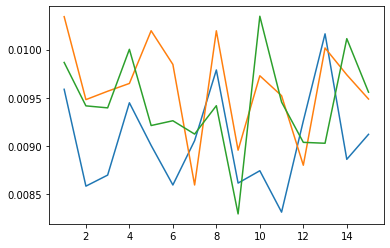

In [112]:
bench.plot_simu_medians()

In [0]:
%%capture
bench.check_scale([10, 20, 50, 100, 500, 1000], num_offline_users=100, num_online_users=100)

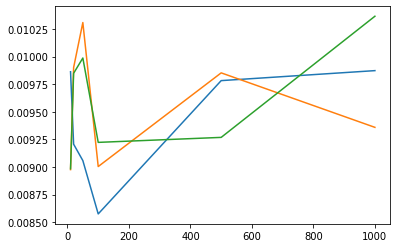

In [114]:
bench.plot_scale_res()